# Linear Regression and Model Selection on Advertising Data
Let's take a look at some advertising data, and then fill in the missing code using the provided hints and answer the questions in 1-2 sentences (Each ... indicates missing code or answer).

What are the **features**?
- TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
- Radio: advertising dollars spent on Radio 1
- Radio 2: advertising dollars spent on Radio 2
- Newspaper: advertising dollars spent on Newspaper
- Area: the location

What is the **response**?
- Sales: sales of a single product in a given market (in thousands of widgets)

There are 200 **observations**, and thus 200 markets in the dataset.

In [21]:
# imports
import pandas as pd
import numpy as np

In [22]:
##fill in the missing code to read data into a DataFrame using read_csv in pandas package
data = pd.read_csv("Advertising.csv")
data = data.dropna()
data.head()

,Unnamed: 0,TV,radio,radio_2,newspaper,area,sales
0,1,230.1,37.8,75.6,69.2,rural,22.1
1,2,44.5,39.3,78.6,45.1,urban,10.4
2,3,17.2,45.9,91.8,69.3,rural,9.3
3,4,151.5,41.3,82.6,58.5,urban,18.5
4,5,180.8,10.8,21.6,58.4,suburban,12.9


## Fitting the data to a Linear model (4 pts)
Let's try to fitting a linear regression model immediately to the given dataset

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
##fill in the feature list
feature_cols = ["TV", "radio","radio_2","newspaper", "area"]
X = data[feature_cols].values
y = data.sales.values

## instantiate a Linear Regression model and fit to the data
model = LinearRegression().fit(X, y)

# print coefficients
print(feature_cols, model.coef_)

ValueError: could not convert string to float: 'rural'

**Question**: What is the output of this first attempt to fit a Linear Regression model? Explain the output in 1-2 sentences.

The first attempt to fit the Linear Regression was unsuccessful because one of the features is categorical. This feature needs to be encoded into binary values for the computer to be able to read the data without assuming wrong information about it. To do this we can use One-Hot encoding. 

## Handling Categorical Features via One-Hot Encoding (4 pts)

We have to represent **area** numerically, but we can't simply code it as 0=rural, 1=suburban, 2=urban because that would imply an **ordered relationship** between suburban and urban (and thus urban is somehow "twice" the suburban category).

**Question: How many variables need to be created and why? **

We need to create 3 new variables, each for a type of area: rural, suburban and urban. The reason is that in this way only one variable will be active at a time and we will not have the problem of the model assuming some ordered relationship among them 

**Question: Intepret the encoding**

- **rural** is coded as 1 in the new variable "area_rural" if the value in the variable "area" is "rural". 0 otherwise. 
- **suburban** is coded as 1 in the new variable "area_suburban" if the value in the variable "area"  is "suburban". 0 otherwise. 
- **urban** is coded as 1 in the new variable "area_urban" if the value in the variable "area" is "urban". 0 otherwise.  

In [25]:
## create three dummy variables using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(data, prefix=["area"])
area_dummies = area_dummies[["area_rural","area_suburban","area_urban"]]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, area_dummies], axis=1)
data.head()

,Unnamed: 0,TV,radio,radio_2,newspaper,area,sales,area_rural,area_suburban,area_urban
0,1,230.1,37.8,75.6,69.2,rural,22.1,1,0,0
1,2,44.5,39.3,78.6,45.1,urban,10.4,0,0,1
2,3,17.2,45.9,91.8,69.3,rural,9.3,1,0,0
3,4,151.5,41.3,82.6,58.5,urban,18.5,0,0,1
4,5,180.8,10.8,21.6,58.4,suburban,12.9,0,1,0


Let's include the new dummy variables in the model:

In [26]:
## your new list of features
feature_cols = ["TV", "radio","radio_2","newspaper", "area_rural","area_suburban","area_urban"]
X = data[feature_cols].values

from sklearn import preprocessing

## Min max feature scaling using MinMaxScaler from sklearn
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X)
X = min_max_scaler.transform(X)

## instantiate, fit
model = LinearRegression().fit(X, y)

# print coefficients
for i in range(len(feature_cols)):
    print(feature_cols[i], "\tcoeficient\t", model.coef_[i]) 

print("\n The intercept is", model.intercept_)

TV 	coeficient	 13.543739378660407
radio 	coeficient	 4.652897200498308
radio_2 	coeficient	 4.652897200498319
newspaper 	coeficient	 -0.11576352153642161
area_rural 	coeficient	 -0.04521055626749814
area_suburban 	coeficient	 -0.16310085190900708
area_urban 	coeficient	 0.20831140817649868

 The intercept is 2.9970909405628063


**Question:** Holding all other variables fixed, how do we interpret the coefficients of dummy variables?
- Being a **suburban** area is associated with an average of 16% less sales than other geographical areas
- Being an **urban** area is associated with an average of 20% more sales than other geographical areas

**Question:** What are the coefficients of radio and radio_2 features are look like? How does it possibly happen (1-2 sentences)?

The coefficients are very similar. This could happen because the two radio stations are perfect substitutes among radio listeners. This means we are facing collinearity among these two variables. We would need to test for it before understanding what is the real reason this is happening. 

## Handling Collinearity using VIF (4 pts)

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## use variance_inflation_factor to compute VIF scores for the features 
vif = [variance_inflation_factor(X,i) for i in range(X.shape[1])]

print(vif)

[1.0056448886982599, inf, inf, 1.1471311872820646, 2.7812685984480585, 3.1449780274265886, 2.8983810001513888]


/Users/emmanuel/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


**Question:** Based on the VIF values, what features are collinear and what features can we remove to elimiate collinearity?

The two radio variables are colinear. I will remove the second one to eliminate this problem. 


**Recompute VIF scores after removing that feature

In [28]:
## Your new list of features after removing collinear features
feature_cols = ["TV", "radio","newspaper", "area_rural","area_suburban","area_urban"]
X = data[feature_cols].values

## Min max feature scaling
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X)
X = min_max_scaler.transform(X)

## Compute VIF scores for all remaining features
vif = [variance_inflation_factor(X,i) for i in range(X.shape[1])]

print(vif)

[1.0056448886982596, 1.1526097040655914, 1.1471311872820646, 2.7812685984480585, 3.1449780274265877, 2.8983810001513888]


**Question:** How do the VIF scores for these fetures look like?

The VIF scores indicate that there is no collinearity among the different features. 

## Handling Ourliers (4 pts)
Let's try to identify ourliers from our dataset using residual plot and seaborn package

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

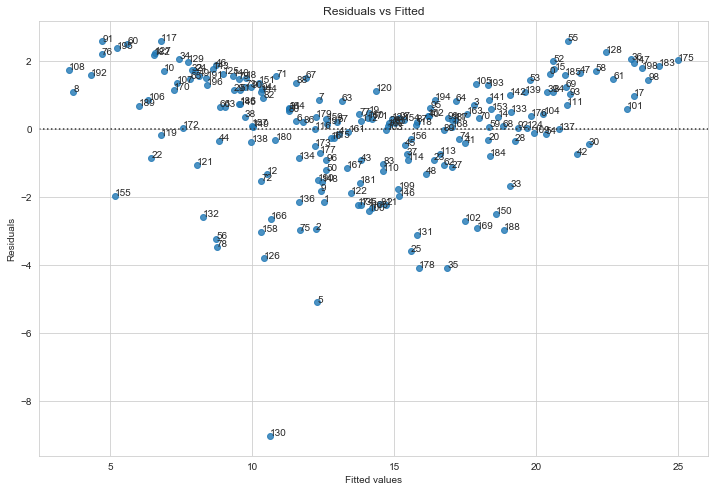

In [30]:


## instantiate, fit a linear regression model
model = LinearRegression().fit(X, y) 

## compute predicted values and residuals
y_pred = model.predict(X)
y_resid = y - y_pred

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

## use residplot from seaborn to draw the residual plot
plot_lm_1.axes[0] =sns.residplot(y_pred, y_resid)

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
for i in range(len(y)):
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   y_resid[i]));

**Question:** Find the point with highest residual and remove it from the data. Retrain the model and draw the residual plot again to confirm that the outlier has been removed

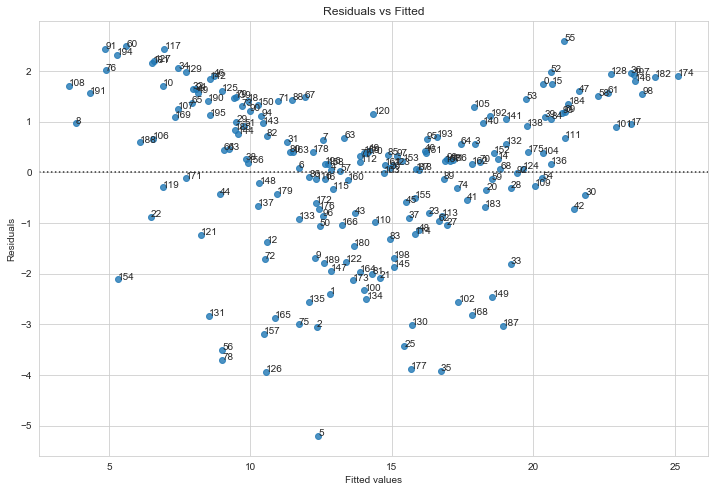

In [31]:
## remove point with highest residual from our data
mask = [i for i in range(len(y_resid)) if y_resid[i] > -6]

X = X[mask,:]
y = y[mask]

## train another linear regression model
model = LinearRegression().fit(X,y)

y_pred = model.predict(X)
y_resid = y - y_pred

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

## use residplot from seaborn to draw the residual plot
plot_lm_1.axes[0] = sns.residplot(y_pred, y_resid)

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
for i in range(len(y)):
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   y_resid[i]));

## Linear Regression and GridSearchCV Model Selection in scikit-learn (4 pts)

Let's fit a Linear Regression model with ridge regularization and do model selection to select regularization constant. Fill in the missing code using the hints

In [32]:
# follow the usual sklearn pattern: import, instantiate, fit

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

kcv = KFold(n_splits=5, shuffle=True)
parameters = {'alpha':np.logspace(-3, 3, 7)}
model = Ridge()
score = 0

# Evaluate model by 5 fold cross validation
for train_index, test_index in kcv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ## Use GridSearchCV to select regularization constant
    cmodel = GridSearchCV(model, param_grid =parameters, cv = kcv, 
                          scoring='neg_mean_absolute_error', n_jobs = -2, return_train_score = True)
    cmodel.fit(X_train, y_train.ravel())
    
    ## Train Ridge on traning data using the selected regularization constant
    model = Ridge(alpha = cmodel.best_estimator_.alpha)
    model.fit(X_train, y_train)
    
    score += model.score(X_test, y_test)

print('Model score', score/5)

Model score 0.9026932913670468
